Deep Learning
=============

Assignment Sparse Autoencoder
------------

Structured from `2_fullyconnected.ipynb`

The goal of this assignment is to train a sparse autoencoder network on MNIST Data and visulize its validation data reconstruction.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

First we load the MNIST data

In [2]:
data_set = input_data.read_data_sets('', False)
training_data=data_set.train
testing_data=data_set.test

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz


Checking  the data

In [3]:
images_feed, labels_feed = training_data.next_batch(10000,False)
image_size = 28
num_labels=10
np.min(images_feed)

0.0

In [4]:
training_data.next_batch(10)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32),
 array([5, 1, 1, 3, 6, 2, 6, 3, 3, 1], dtype=uint8))

In [5]:
print(feature_weights.shape)
features=feature_weights.transpose()  
print(features.shape)
fig = plt.figure()
for i in range(100):
   ax = fig.add_subplot(10,10,i)
   ax.imshow(batch_data[i].reshape(image_size,image_size), cmap=cm.gray)

NameError: name 'feature_weights' is not defined

Do validation testing:
- data as a flat matrix,


In [6]:
validation_data=data_set.validation
valid_batch,validation_labels=validation_data.next_batch(validation_data.num_examples)

In [7]:
batch_size = 128
nHidden=196
beta=3
rho=.1

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_valid_dataset = tf.constant(valid_batch)
  #tf_test_dataset = tf.constant(test_dataset)
   
  # Variables.
  weights_hidden1 = tf.Variable(tf.truncated_normal([image_size * image_size, nHidden],stddev=0.01))
  weights = tf.Variable(tf.truncated_normal([nHidden, image_size*image_size],stddev=0.01))
  biases_hidden1 = tf.Variable(tf.zeros([nHidden]))
  biases = tf.Variable(tf.zeros([image_size*image_size]))
  
  # Training computation.
  hidden_comp=tf.matmul(tf_train_dataset, weights_hidden1)
  hidden1 = tf.nn.sigmoid(tf.mul(hidden_comp  + biases_hidden1,8))
  output_units = tf.nn.sigmoid(tf.matmul(hidden1, weights) + biases)
  int_rho=tf.reduce_sum(hidden1,0)
  rho_hat=tf.div(int_rho,batch_size)
  rho_hat_mean=tf.reduce_mean(rho_hat)
  rho_in=tf.sub(tf.constant(1.),rho)
  rho_hat_in=tf.sub(tf.constant(1.),rho_hat)
  klterm=tf.add(tf.mul(rho,tf.log(tf.div(rho,rho_hat))),tf.mul(rho_in,tf.log(tf.div(rho_in,rho_hat_in))))
  kl_div=tf.reduce_sum(klterm)
  loss = tf.div(tf.nn.l2_loss(tf.sub(output_units, tf_train_dataset)),tf.constant(float(batch_size)))+ beta*kl_div
            
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.0075).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  valid_output_units=tf.nn.sigmoid(tf.matmul(tf.nn.sigmoid(tf.mul(tf.matmul(tf_valid_dataset, weights_hidden1)  + biases_hidden1,8)),weights)+biases)
  valid_loss= tf.div(tf.nn.l2_loss(tf.sub(valid_output_units, tf_valid_dataset)),tf.constant(float(batch_size)))
    #l2_loss variation check
    #adaptive beta
    #sigmoid output

In [8]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    # Generate a minibatch.
    batch_data,_ = training_data.next_batch(batch_size)
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data}
    _, l, feature_weights, feature_biases, rhohat= session.run(
      [optimizer, loss, weights_hidden1, biases_hidden1, rho_hat_mean], feed_dict=feed_dict)
    if step%500==0:
        _, v_l, valid_out_data = session.run([optimizer, valid_loss,valid_output_units], feed_dict=feed_dict)
        print("step", step," \tTrain loss ",l, "\tValid loss",v_l, "\t Mean Rho-hat",rhohat)
        
# for i in xrange(batch_size):
    #        plt.imshow(features[i].reshape(image_size,image_size), cmap=cm.gray)

Initialized
step 0  	Train loss  321.8 	Valid loss 3541.14 	 Mean Rho-hat 0.504439
step 500  	Train loss  51.2417 	Valid loss 1830.29 	 Mean Rho-hat 0.123292
step 1000  	Train loss  35.1781 	Valid loss 1211.82 	 Mean Rho-hat 0.128728
step 1500  	Train loss  28.9032 	Valid loss 1004.39 	 Mean Rho-hat 0.128866
step 2000  	Train loss  26.3776 	Valid loss 873.963 	 Mean Rho-hat 0.119205
step 2500  	Train loss  23.4443 	Valid loss 816.198 	 Mean Rho-hat 0.120469
step 3000  	Train loss  22.3311 	Valid loss 755.86 	 Mean Rho-hat 0.117665
step 3500  	Train loss  21.6369 	Valid loss 717.157 	 Mean Rho-hat 0.115398
step 4000  	Train loss  19.2381 	Valid loss 687.138 	 Mean Rho-hat 0.116069
step 4500  	Train loss  18.8848 	Valid loss 655.835 	 Mean Rho-hat 0.114426
step 5000  	Train loss  19.3627 	Valid loss 631.719 	 Mean Rho-hat 0.124685
step 5500  	Train loss  18.5342 	Valid loss 607.9 	 Mean Rho-hat 0.118937
step 6000  	Train loss  16.7894 	Valid loss 594.151 	 Mean Rho-hat 0.117825
step 6500

## Displaying the reconstruction of first 100 input images in validation by trained sparse autoencoder

(784, 196)
(196, 784)


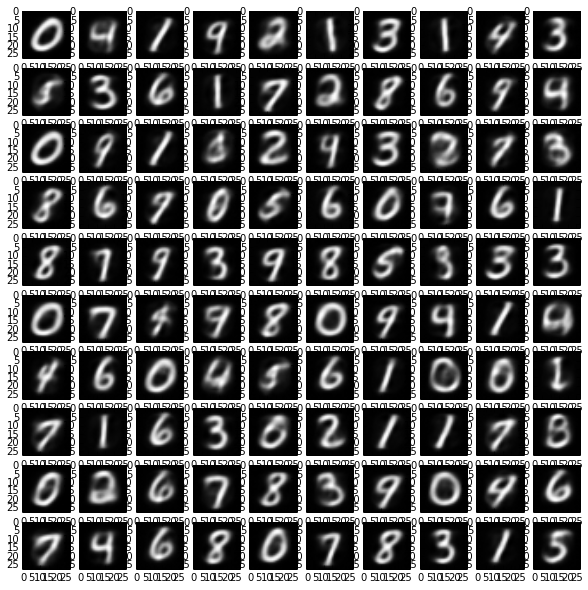

In [9]:
print(feature_weights.shape)
features=feature_weights.transpose()  
print(features.shape)

fig = plt.figure(figsize = (10,10))
for i in range(100):
   ax = fig.add_subplot(10,10,i)
   ax.imshow(valid_out_data[i].reshape(image_size,image_size), cmap=cm.gray)

### Displaying the first 100 features used to do the reconstruction

(784, 196)
(196, 784)


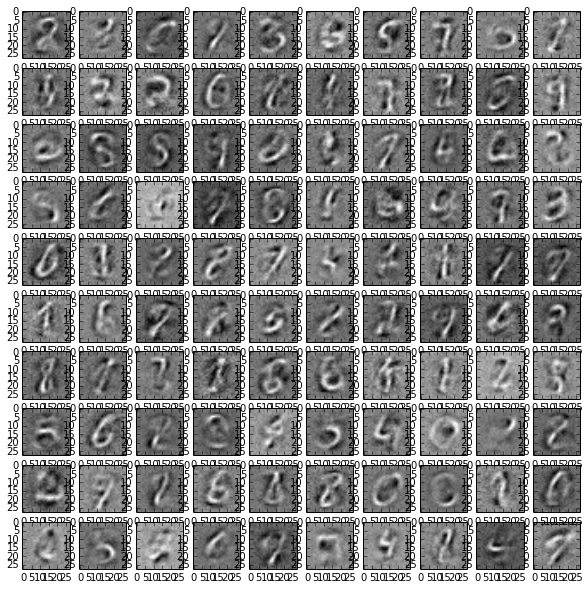

In [39]:
print(feature_weights.shape)
features=feature_weights.transpose()  
print(features.shape)

fig = plt.figure(figsize = (10,10))
for i in range(100):
   ax = fig.add_subplot(10,10,i)
   ax.imshow(features[i].reshape(image_size,image_size), cmap=cm.gray)

## Training Softmax Classifier

In [10]:
test_dataset,testing_labels=testing_data.next_batch(testing_data.num_examples)

In [14]:
batch_size = 128
num_labels=10
nHidden=196
beta=3
rho=.1
tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  weights_hidden1 = tf.constant(feature_weights)
  biases_hidden1 = tf.constant(feature_biases)
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_batch)
  tf_test_dataset = tf.constant(test_dataset)
   
  # Variables.
  logit_weights= tf.Variable(tf.truncated_normal([nHidden, num_labels]))
  logit_biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden1 = tf.nn.sigmoid(tf.mul(tf.matmul(tf_train_dataset, weights_hidden1)  + biases_hidden1,8))
  logits = tf.matmul(hidden1, logit_weights) + logit_biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(
    tf.nn.sigmoid(tf.matmul(tf_valid_dataset, weights_hidden1) + biases_hidden1), logit_weights) + logit_biases)
  test_prediction = tf.nn.softmax(tf.matmul(
    tf.nn.sigmoid(tf.matmul(tf_test_dataset, weights_hidden1) + biases_hidden1), logit_weights) + logit_biases)

In [15]:
def reformat(labels):
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return labels

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [ ]:
num_steps = 20001
valid_labels=reformat(validation_labels)
test_labels=reformat(testing_labels)
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    batch_data,labels= training_data.next_batch(batch_size)
    batch_labels=reformat(labels)
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 6.573428
Minibatch accuracy: 8.6%
Validation accuracy: 8.2%
Minibatch loss at step 500: 5.451642
Minibatch accuracy: 10.2%
Validation accuracy: 9.4%
Minibatch loss at step 1000: 6.131121
Minibatch accuracy: 10.9%
Validation accuracy: 10.4%
Minibatch loss at step 1500: 5.147552
Minibatch accuracy: 14.1%
Validation accuracy: 11.7%
Minibatch loss at step 2000: 4.907185
Minibatch accuracy: 15.6%
Validation accuracy: 12.8%
Minibatch loss at step 2500: 3.941446
Minibatch accuracy: 25.0%
Validation accuracy: 13.5%
Minibatch loss at step 3000: 4.117170
Minibatch accuracy: 13.3%
Validation accuracy: 14.3%
Minibatch loss at step 3500: 3.950014
Minibatch accuracy: 21.1%
Validation accuracy: 15.1%
Minibatch loss at step 4000: 4.186459
Minibatch accuracy: 22.7%
Validation accuracy: 16.0%
Minibatch loss at step 4500: 3.363178
Minibatch accuracy: 29.7%
Validation accuracy: 16.8%
Minibatch loss at step 5000: 4.192286
Minibatch accuracy: 19.5%
Validation accuracy: 